# CIFAR-10: Convolutional Neural Networks


This dataset contains 60,000 images. It has 10 different classes. THe images are 32x32X3. They are colored images. Because they are colored images we are going to use GPU. 
GPU allows data processing to be done in parallel which speeds up training time.

In [124]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

CUDA is available! Training on GPU...


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

In [5]:
train_data = datasets.CIFAR10('data', train=True, download=True,
                             transform=transform)

test_data = datasets.CIFAR10('data', train=False, download=True, 
                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [88]:
# number of processors to use for data loading
num_workers = 0

batch_size = 20

valid_size = 0.2


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparing the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers)

In [89]:
# specifying the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck']

In [90]:
images, labels = next(iter(train_loader))

In [117]:
def show_image(images, num_of_images):
    
    fig = plt.figure(figsize=(25,4))
    
    for index in range(num_of_images):
        img = images[index] / 2 + 0.5
        img = np.transpose(img, (1,2,0))
        
        ax = fig.add_subplot(2, num_of_images/2, index+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(classes[labels[index]])

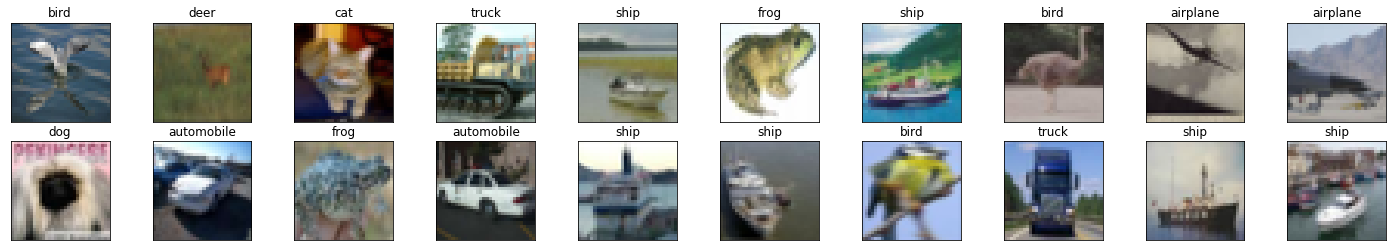

In [118]:
show_image(images, num_of_images=20)

In [130]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

In [122]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [131]:
# moving the tensors to GPU
if train_on_gpu:
    model.cuda()

In [132]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 8

valid_loss_min = np.inf

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for images, labels in train_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    # validating the model
    model.eval()
    for images, labels in valid_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        
    # calculating the losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    
    print(f'Epoch: {epoch+1} \nTraining loss: {train_loss} \nValidation loss: {valid_loss}')
    
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation decreased from {valid_loss_min} to {valid_loss}.')
        print('Saving the model ...')
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 
Training loss: 0.10750999276041985 
Validation loss: 0.09544203833341598
Validation decreased from inf to 0.09544203833341598.
Saving the model ...
Epoch: 2 
Training loss: 0.08663330787420273 
Validation loss: 0.08100153404474258
Validation decreased from 0.09544203833341598 to 0.08100153404474258.
Saving the model ...
Epoch: 3 
Training loss: 0.07653233615309 
Validation loss: 0.07324870394468308
Validation decreased from 0.08100153404474258 to 0.07324870394468308.
Saving the model ...
Epoch: 4 
Training loss: 0.0711221278309822 
Validation loss: 0.07218075104355812
Validation decreased from 0.07324870394468308 to 0.07218075104355812.
Saving the model ...
Epoch: 5 
Training loss: 0.06732095350623131 
Validation loss: 0.06630656810998917
Validation decreased from 0.07218075104355812 to 0.06630656810998917.
Saving the model ...
Epoch: 6 
Training loss: 0.06414739848971367 
Validation loss: 0.06732690904140472
Epoch: 7 
Training loss: 0.061402873545885084 
Validation loss: 0.0